## Import Libraries and Data

In [13]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_2407-0308-2023.csv', firstRow=672, lastRow=678)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_240723_S673-678.csv',t_baseline=20,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [14]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=46s and ended at t=446s; mass=44.65475g
This equals a volume of 44.744m; expected was 44.877mL; error is 0.296%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.0015 g/s and for 2nd derivative = 0.0009375 g/s^2


<IPython.core.display.Javascript object>


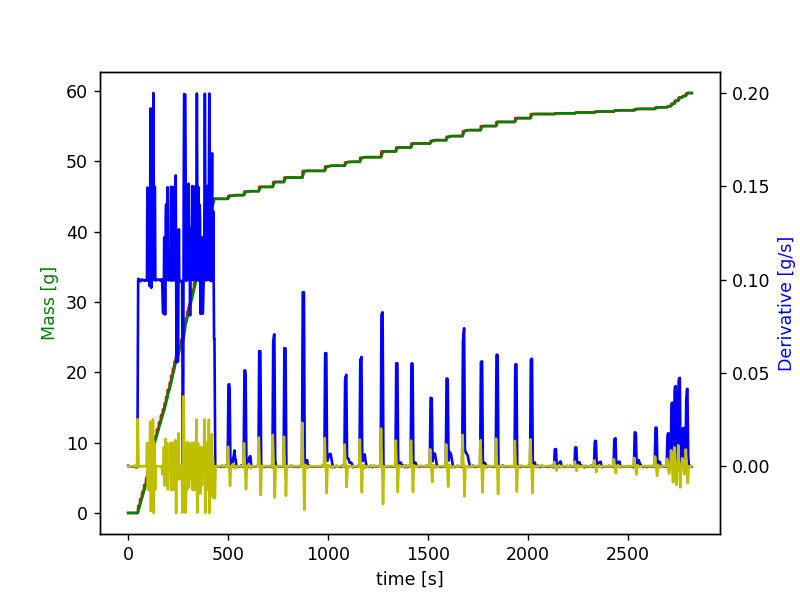

Addition of 0.522g Texapon SB 3 KC detected from 496s to 544s - expected volume = 0.779mL and actual volume = 0.468mL (resulting error is 39.839%)
Addition of 0.561g Texapon SB 3 KC detected from 576s to 618s - expected volume = 0.568mL and actual volume = 0.509mL (resulting error is 10.407%)
Addition of 0.617g Texapon SB 3 KC detected from 650s to 670s - expected volume = 0.568mL and actual volume = 0.559mL (resulting error is 1.516%)
Addition of 0.702g Texapon SB 3 KC detected from 720s to 742s - expected volume = 0.576mL and actual volume = 0.635mL (resulting error is 10.267%)
Addition of 0.63g Texapon SB 3 KC detected from 776s to 796s - expected volume = 0.576mL and actual volume = 0.569mL (resulting error is 1.146%)
Addition of 0.963g Plantapon ACG 50 detected from 868s to 900s - expected volume = 0.928mL and actual volume = 0.855mL (resulting error is 7.809%)
Addition of 0.74g Plantapon LC 7 detected from 980s to 1024s - expected volume = 0.95mL and actual volume = 0.701mL (resu

In [15]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.0015625 g/s and for 2nd derivative = 0.001015625 g/s^2


<IPython.core.display.Javascript object>


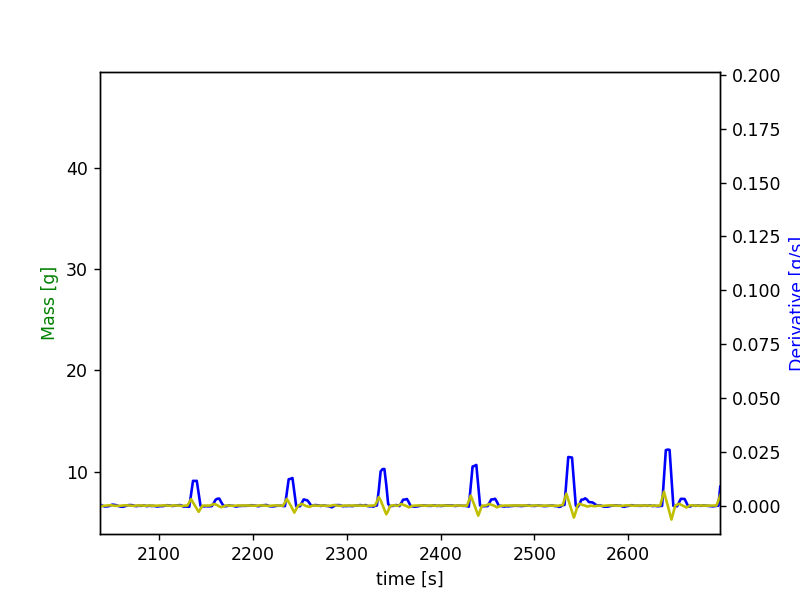

Addition of 0.108g Salcare Super 7 detected from 2130s to 2170s - expected volume = 0.142mL and actual volume = 0.098mL (resulting error is 30.849%)
Addition of 0.118g Salcare Super 7 detected from 2232s to 2262s - expected volume = 0.107mL and actual volume = 0.106mL (resulting error is 0.945%)
Addition of 0.155g Salcare Super 7 detected from 2330s to 2370s - expected volume = 0.123mL and actual volume = 0.141mL (resulting error is 14.537%)
Addition of 0.167g Salcare Super 7 detected from 2428s to 2464s - expected volume = 0.15mL and actual volume = 0.152mL (resulting error is 1.364%)
Addition of 0.214g Salcare Super 7 detected from 2530s to 2564s - expected volume = 0.187mL and actual volume = 0.195mL (resulting error is 3.944%)
Addition of 0.227g Salcare Super 7 detected from 2634s to 2664s - expected volume = 0.212mL and actual volume = 0.205mL (resulting error is 3.404%)


In [17]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=8, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

#t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2014,2112,2210,2314,2412,2494,2564])

## Analyse Thickeners

Peak threshold for 1st derivative = 0.005 g/s and for 2nd derivative = 0.001 g/s^2


<IPython.core.display.Javascript object>


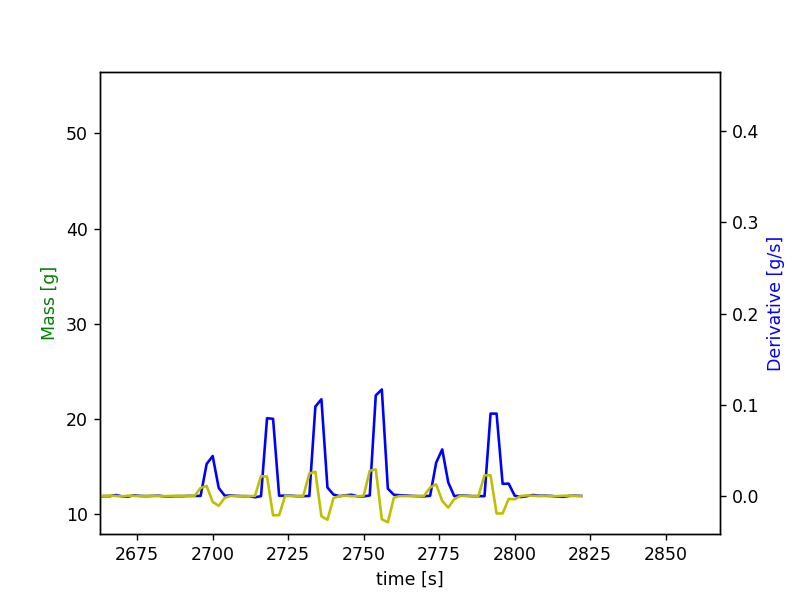

Addition of 0.176g Arlypon TT detected from 2694s to 2708s - expected volume = 0.188mL and actual volume = 0.185mL (resulting error is 1.397%)
Addition of 0.337g Arlypon TT detected from 2714s to 2726s - expected volume = 0.343mL and actual volume = 0.352mL (resulting error is 2.432%)
Addition of 0.429g Arlypon TT detected from 2730s to 2744s - expected volume = 0.426mL and actual volume = 0.453mL (resulting error is 6.312%)
Addition of 0.474g Arlypon TT detected from 2750s to 2764s - expected volume = 0.469mL and actual volume = 0.498mL (resulting error is 6.278%)
Addition of 0.205g Arlypon TT detected from 2770s to 2784s - expected volume = 0.145mL and actual volume = 0.215mL (resulting error is 48.188%)
Addition of 0.41g Arlypon TT detected from 2788s to 2804s - expected volume = 0.405mL and actual volume = 0.429mL (resulting error is 5.799%)


In [18]:
# default bl_mult = 1, default mergeSens = 1
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

#t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2600,2616,2636,2656,2676,2884,2906])

## Consolidate results and create output

In [19]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_240723_S673-S678.csv', index=False)
actualMassFractions

C:\Users\ACHI01\AppData\Local\Temp\ipykernel_20488\3415163425.py:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for entry in sampleList[i].addedMassSeries.iteritems():


,ID,Texapon SB 3 KC,Plantapon ACG 50,Plantapon LC 7,Plantacare 818,Plantacare 2000,Dehyton MC,Dehyton PK 45,Dehyton ML,Dehyton AB 30,Plantapon Amino SCG-L,Plantapon Amino KG-L,Dehyquart A-CA,Luviquat Excellence,Dehyquart CC6,Dehyquart CC7 Benz,Salcare Super 7,Arlypon F,Arlypon TT
672,673.0,0.000000,9.615362,0.000000,0.0,0.000000,0.0,8.235038,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.076663,0.0,1.761585
673,674.0,5.341063,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,11.608784,0.0,0.0,0.0,0.0,1.205626,0.0,3.446837
674,675.0,11.763462,0.000000,0.000000,0.0,0.000000,0.0,0.000000,10.566450,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,1.543686,0.0,4.287878
675,676.0,12.989625,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,11.436253,0.000000,0.0,0.0,0.0,0.0,1.630895,0.0,4.622087
676,677.0,0.000000,0.000000,0.000000,0.0,12.023832,0.0,0.000000,8.414612,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,2.111542,0.0,2.016627
677,678.0,0.000000,0.000000,7.468709,0.0,0.000000,0.0,11.441127,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,2.289839,0.0,4.140877
